## 2D Hatic Search Model

1. Make suction cup shape
n = number of chambers
r = radius of the mouse for the suction cup

## Code for the finalized with basic GUI

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
from shapely.geometry.polygon import orient
from shapely.affinity import rotate
import tkinter as tk
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

class PolygonObject:
    def __init__(self, shape, width, height, position=(0, 0), concave_angle=180):
        self.shape = shape
        self.width = width
        self.height = height
        self.position = position
        self.concave_angle = concave_angle
        self.polygon = self.create_polygon()

    def create_polygon(self):
        x, y = self.position
        if self.shape == "Rectangle":
            coords = [(x, y), (x + self.width, y), (x + self.width, y + self.height), (x, y + self.height)]
        elif self.shape == "Circle":
            coords = [(x + self.width/2 * np.cos(t), y + self.width/2 * np.sin(t)) for t in np.linspace(0, 2*np.pi, 100)]
        elif self.shape == "Ellipse":
            coords = [(x + self.width/2 * np.cos(t), y + self.height/2 * np.sin(t)) for t in np.linspace(0, 2*np.pi, 100)]
        elif self.shape == "Concave":
            coords = [(x, y), (x + self.width, y), (x + self.width, y + self.height), (x, y + self.height)]
            concave_point = ((x + self.height / 2 / np.tan(np.radians(self.concave_angle / 2))), (y + self.height / 2 ))
            if self.concave_angle != 180:
                coords.insert(4, concave_point)
        else:
            raise ValueError("Unsupported shape")

        return Polygon(coords)

    def draw(self, ax):
        if self.shape == "Rectangle":
            rect = plt.Rectangle(self.position, self.width, self.height, linewidth=1, edgecolor='black', facecolor='none')
            ax.add_patch(rect)
        else:
            poly = plt.Polygon(self.polygon.exterior.coords, linewidth=1, edgecolor='black', facecolor='none')
            ax.add_patch(poly)

class SuctionCup:
    def __init__(self, num_chambers, radius, center=(0, 0), rotation_angle=0):
        self.num_chambers = num_chambers
        self.radius = radius  # in mm
        self.center = center
        self.rotation_angle = rotation_angle
        self.chambers = self.create_chambers()
        # self.subtract_bars()

    def create_chambers(self):
        angles = np.linspace(0, 2 * np.pi, self.num_chambers + 1)
        chambers = []
        for i in range(self.num_chambers):
            theta = np.linspace(angles[i], angles[i + 1], 100)
            x = np.append([self.center[0]], self.center[0] + np.cos(theta) * self.radius)
            y = np.append([self.center[1]], self.center[1] + np.sin(theta) * self.radius)
            chamber_points = list(zip(x, y))
            chamber_polygon = Polygon(chamber_points)
            chamber_polygon = orient(chamber_polygon, sign=1.0)
            chamber_polygon = rotate(chamber_polygon, self.rotation_angle, origin=self.center)
            chambers.append(chamber_polygon)
        return chambers

    def create_bars(self):
        bars = []
        bar_thickness = 0.8  # Adjust thickness as needed
        angle_increment = 360 / self.num_chambers

        for i in range(self.num_chambers):
            angle = i * angle_increment
            bar = Polygon([(-bar_thickness / 2, -self.radius), (bar_thickness / 2, -self.radius), 
                           (bar_thickness / 2, self.radius), (-bar_thickness / 2, self.radius)])
            bar = rotate(bar, angle, origin=(0, 0))
            bars.append(bar)

        return bars

    def subtract_bars(self):
        bars = self.create_bars()
        for bar in bars:
            self.chambers = [chamber.difference(bar) for chamber in self.chambers]

    def draw(self, ax):
        colors = plt.cm.get_cmap('hsv', self.num_chambers)
        for i, chamber in enumerate(self.chambers):
            x, y = chamber.exterior.xy
            ax.fill(x, y, color=colors(i), alpha=0.5, label=f'Chamber {i + 1}')
            ax.text((x[0] + x[50]) / 2, (y[0] + y[50]) / 2, f'Ch{i + 1}', ha='center', va='center', fontsize=8, color='black')


def calculate_covered_area(polygon, chambers):
    covered_areas = [polygon.intersection(chamber).area for chamber in chambers]
    return covered_areas

def calculate_vacuum_pressures(covered_areas, suctioncup):
    a = 4.007e4
    b = 0.6895
    total_area = np.pi * (suctioncup.radius ** 2) * 1e-6  # Convert to m^2
    total_chamber_area = total_area / suctioncup.num_chambers
    
    r_total = np.sum(covered_areas) * 1e-6 / total_area  # Convert covered areas to m^2
    covered_areas = np.array(covered_areas) * 1e-6  # Ensure it's a NumPy array and convert to m^2
    r_chamber = covered_areas / total_chamber_area
    
    alpha = 0.5 * (r_chamber - r_total)
    P_m = a * total_area + 2 * b
    P_avg = 10 ** (a * np.sum(covered_areas) + b)
    
    vacuum_pressures = [10 ** (alpha_i * P_m) * P_avg ** (1 - alpha_i) for alpha_i in alpha]
    
    return vacuum_pressures

def calculate_unit_vectors(num_chambers, rotation_angle):
    return [np.array([np.cos(2 * np.pi / (num_chambers * 2) + 2 * np.pi * i / num_chambers + np.radians(rotation_angle)),
                      np.sin(2 * np.pi / (num_chambers * 2) + 2 * np.pi * i / num_chambers + np.radians(rotation_angle))])
            for i in range(num_chambers)]

def calculate_direction_vector(unit_vectors, vacuum_pressures):
    direction_vector = np.sum([vp * uv for vp, uv in zip(vacuum_pressures, unit_vectors)], axis=0)
    return direction_vector / np.linalg.norm(direction_vector)

def calculate_direction_errors(direction_vector, target_vector):

    # Calculate the dot product
    dot_product = np.dot(direction_vector, target_vector)

    # Calculate the angle in radians between two vectors
    angle = np.arccos(dot_product)

    # Convert the angle to degrees
    angle = np.degrees(angle)

    return angle


def visualize_and_calculate_coverage(polygon_obj, suction_cup):
    fig, ax = plt.subplots()

    polygon_obj.draw(ax)
    suction_cup.draw(ax)

    ax.set_aspect('equal')
    limit = max(polygon_obj.width, polygon_obj.height, suction_cup.radius) * 1.5
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    ax.axis('off')

    covered_areas_list = calculate_covered_area(polygon_obj.polygon, suction_cup.chambers)
    covered_areas = covered_areas_list  # Already in mm^2, no need to convert here
    total_chamber_area = (np.pi * (suction_cup.radius ** 2)) / suction_cup.num_chambers  # in mm^2

    vacuum_pressures = calculate_vacuum_pressures(covered_areas, suction_cup)
    unit_vectors = calculate_unit_vectors(suction_cup.num_chambers, suction_cup.rotation_angle)
    for vector in unit_vectors:
        ax.quiver(*suction_cup.center, *vector, angles='xy', scale_units='xy', scale=20, color='b')

    print("unit vectors: ", unit_vectors)
    weighted_sum = calculate_direction_vector(unit_vectors, vacuum_pressures)
    print("weighted sum: ", weighted_sum)
    target_vector = np.array([1, 0])  # Unit vector toward positive x direction
    direction_error = calculate_direction_errors(weighted_sum, target_vector)

    for intersection in suction_cup.chambers:
        if not intersection.is_empty:
            x, y = intersection.exterior.xy
            ax.fill(x, y, color='gray', alpha=0.3)
    
    plt.legend()
    return fig, covered_areas, total_chamber_area, vacuum_pressures, direction_error

class SuctionCupGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("Suction Cup GUI")

        self.shape = tk.StringVar(value="Rectangle")
        self.num_chambers = tk.IntVar(value=4)
        self.suction_radius = tk.DoubleVar(value=5)
        self.width = tk.DoubleVar(value=30)
        self.height = tk.DoubleVar(value=10)
        self.suction_x = tk.DoubleVar(value=0)
        self.suction_y = tk.DoubleVar(value=5)
        self.rotation_angle = tk.DoubleVar(value=0)
        self.concave_angle = tk.DoubleVar(value=180)

        self.create_widgets()
        self.update_plot()

    def create_widgets(self):
        params_frame = ttk.Frame(self.root)
        params_frame.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

        plot_frame = ttk.Frame(self.root)
        plot_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)

        ttk.Label(params_frame, text="Shape").pack()
        shape_menu = ttk.OptionMenu(params_frame, self.shape, "Rectangle", "Rectangle", "Circle", "Ellipse", "Concave", command=self.update_plot)
        shape_menu.pack(fill=tk.X)

        ttk.Label(params_frame, text="Number of Chambers").pack()
        ttk.Scale(params_frame, variable=self.num_chambers, from_=3, to=12, orient=tk.HORIZONTAL, command=self.update_plot).pack(fill=tk.X)

        ttk.Label(params_frame, text="Suction Radius").pack()
        ttk.Scale(params_frame, variable=self.suction_radius, from_=0.5, to=5, orient=tk.HORIZONTAL, command=self.update_plot).pack(fill=tk.X)

        ttk.Label(params_frame, text="Width").pack()
        ttk.Scale(params_frame, variable=self.width, from_=1, to=10, orient=tk.HORIZONTAL, command=self.update_plot).pack(fill=tk.X)

        ttk.Label(params_frame, text="Height").pack()
        ttk.Scale(params_frame, variable=self.height, from_=1, to=10, orient=tk.HORIZONTAL, command=self.update_plot).pack(fill=tk.X)

        ttk.Label(params_frame, text="Suction X Position").pack()
        ttk.Scale(params_frame, variable=self.suction_x, from_=-5, to=5, orient=tk.HORIZONTAL, command=self.update_plot).pack(fill=tk.X)

        ttk.Label(params_frame, text="Suction Y Position").pack()
        ttk.Scale(params_frame, variable=self.suction_y, from_=-5, to=5, orient=tk.HORIZONTAL, command=self.update_plot).pack(fill=tk.X)

        ttk.Label(params_frame, text="Rotation Angle").pack()
        ttk.Scale(params_frame, variable=self.rotation_angle, from_=0, to=360, orient=tk.HORIZONTAL, command=self.update_plot).pack(fill=tk.X)

        ttk.Label(params_frame, text="Concave Angle").pack()
        ttk.Scale(params_frame, variable=self.concave_angle, from_=0, to=180, orient=tk.HORIZONTAL, command=self.update_plot).pack(fill=tk.X)

        self.plot_canvas = ttk.Frame(plot_frame)
        self.plot_canvas.pack(fill=tk.BOTH, expand=True)

        self.coverage_frame = ttk.Frame(plot_frame)
        self.coverage_frame.pack(fill=tk.BOTH, expand=True)

        self.coverage_labels = []

    # def update_plot(self, *args):
    #     polygon_obj = PolygonObject(
    #         self.shape.get(),
    #         self.width.get(),
    #         self.height.get(),
    #         (0, 0),
    #         self.concave_angle.get()
    #     )
    #     suction_cup = SuctionCup(
    #         self.num_chambers.get(),
    #         self.suction_radius.get(),
    #         (self.suction_x.get(), self.suction_y.get()),
    #         self.rotation_angle.get()
    #     )

    #     fig, covered_areas, total_chamber_area, vacuum_pressures, direction_error = visualize_and_calculate_coverage(
    #         polygon_obj,
    #         suction_cup
    #     )

    #     for widget in self.plot_canvas.winfo_children():
    #         widget.destroy()

    #     canvas = FigureCanvasTkAgg(fig, master=self.plot_canvas)
    #     canvas.draw()
    #     canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

    #     for label in self.coverage_labels:
    #         label.destroy()
        
    #     self.coverage_labels = []
    #     for i, area in enumerate(covered_areas):
    #         coverage_percentage = (area / total_chamber_area) * 100
    #         label_text = f"Chamber {i+1} covered area: {area:.8f} mm^2 (Coverage: {coverage_percentage:.2f}%), Vacuum Pressure: {vacuum_pressures[i]:.2f}"
    #         label = ttk.Label(self.coverage_frame, text=label_text)
    #         label.pack(fill=tk.X)
    #         self.coverage_labels.append(label)
        
    #     error_label = ttk.Label(self.coverage_frame, text=f"Direction Error: {direction_error:.2f}")
    #     error_label.pack(fill=tk.X)
    #     self.coverage_labels.append(error_label)

    #     plt.close(fig)
    def update_plot(self, *args):
        polygon_obj = PolygonObject(
        self.shape.get(),
        self.width.get(),
        self.height.get(),
        (0, 0),
        self.concave_angle.get()
        )
        suction_cup = SuctionCup(
            self.num_chambers.get(),
            self.suction_radius.get(),
            (self.suction_x.get(), self.suction_y.get()),
            self.rotation_angle.get()
        )

        fig, covered_areas, total_chamber_area, vacuum_pressures, direction_error = visualize_and_calculate_coverage(
            polygon_obj,
            suction_cup
        )

        for widget in self.plot_canvas.winfo_children():
            widget.destroy()

        canvas = FigureCanvasTkAgg(fig, master=self.plot_canvas)
        canvas.draw()
        canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

        # Visualize unit vectors
        ax = fig.gca()
        unit_vectors = calculate_unit_vectors(suction_cup.num_chambers, suction_cup.rotation_angle)
        for uv in unit_vectors:
            ax.quiver(suction_cup.center[0], suction_cup.center[1], uv[0], uv[1], color='blue', angles='xy', scale_units='xy', scale=100)

        for label in self.coverage_labels:
            label.destroy()
        
        self.coverage_labels = []
        for i, area in enumerate(covered_areas):
            coverage_percentage = (area / total_chamber_area) * 100
            label_text = f"Chamber {i+1} covered area: {area:.8f} mm^2 (Coverage: {coverage_percentage:.2f}%), Vacuum Pressure: {vacuum_pressures[i]:.2f}"
            label = ttk.Label(self.coverage_frame, text=label_text)
            label.pack(fill=tk.X)
            self.coverage_labels.append(label)
        
        error_label = ttk.Label(self.coverage_frame, text=f"Direction Error: {direction_error:.2f}")
        error_label.pack(fill=tk.X)
        self.coverage_labels.append(error_label)

        plt.close(fig)

if __name__ == "__main__":
    root = tk.Tk()
    app = SuctionCupGUI(root)
    root.mainloop()


unit vectors:  [array([0.70710678, 0.70710678]), array([-0.70710678,  0.70710678]), array([-0.70710678, -0.70710678]), array([ 0.70710678, -0.70710678])]
weighted sum:  [1. 0.]
unit vectors:  [array([0.66355323, 0.74812907]), array([-0.74812907,  0.66355323]), array([-0.66355323, -0.74812907]), array([ 0.74812907, -0.66355323])]
weighted sum:  [0.99999886 0.00151095]
unit vectors:  [array([0.51930605, 0.85458834]), array([-0.85458834,  0.51930605]), array([-0.51930605, -0.85458834]), array([ 0.85458834, -0.51930605])]
weighted sum:  [ 9.99999966e-01 -2.60186660e-04]
unit vectors:  [array([0.24434041, 0.96968952]), array([-0.96968952,  0.24434041]), array([-0.24434041, -0.96968952]), array([ 0.96968952, -0.24434041])]
weighted sum:  [ 0.99998938 -0.00460963]
unit vectors:  [array([0.18591161, 0.98256647]), array([-0.98256647,  0.18591161]), array([-0.18591161, -0.98256647]), array([ 0.98256647, -0.18591161])]
weighted sum:  [ 0.99999168 -0.00408032]
unit vectors:  [array([0.12681729, 0.

## Code for direction error changes at specific offset

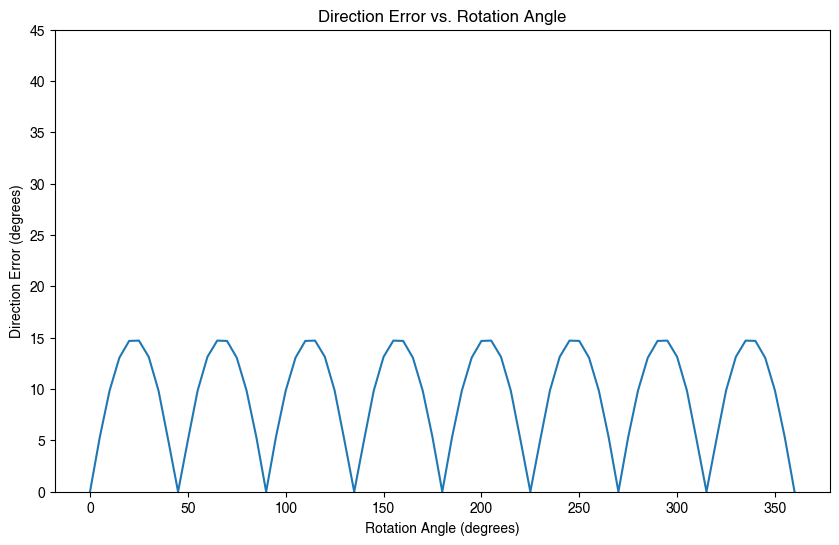

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
from shapely.geometry.polygon import orient
from shapely.affinity import rotate

class PolygonObject:
    def __init__(self, shape, width, height, position=(0, 0), concave_angle=180):
        self.shape = shape
        self.width = width
        self.height = height
        self.position = position
        self.concave_angle = concave_angle
        self.polygon = self.create_polygon()

    def create_polygon(self):
        x, y = self.position
        if self.shape == "Rectangle":
            coords = [(x, y), (x + self.width, y), (x + self.width, y + self.height), (x, y + self.height)]
        elif self.shape == "Circle":
            coords = [(x + self.width/2 * np.cos(t), y + self.width/2 * np.sin(t)) for t in np.linspace(0, 2*np.pi, 100)]
        elif self.shape == "Ellipse":
            coords = [(x + self.width/2 * np.cos(t), y + self.height/2 * np.sin(t)) for t in np.linspace(0, 2*np.pi, 100)]
        elif self.shape == "Concave":
            coords = [(x, y), (x + self.width, y), (x + self.width, y + self.height), (x, y + self.height)]
            concave_point = ((x + self.height / 2 / np.tan(np.radians(self.concave_angle / 2))), (y + self.height / 2 ))
            if self.concave_angle != 180:
                coords.insert(4, concave_point)
        else:
            raise ValueError("Unsupported shape")

        return Polygon(coords)
    
    def draw(self, ax):
        x, y = self.polygon.exterior.xy
        ax.fill(x, y, alpha=0.5, fc='gray', ec='black', label='Polygon')

class SuctionCup:
    def __init__(self, num_chambers, radius, center=(0, 0), rotation_angle=0):
        self.num_chambers = num_chambers
        self.radius = radius  # in mm
        self.center = center
        self.rotation_angle = rotation_angle
        self.chambers_draw = self.create_chambers()
        self.chambers = self.create_chambers()
        # self.subtract_bars()

    def create_chambers(self):
        angles = np.linspace(0, 2 * np.pi, self.num_chambers + 1)
        chambers = []
        for i in range(self.num_chambers):
            theta = np.linspace(angles[i], angles[i + 1], 100)
            x = np.append([self.center[0]], self.center[0] + np.cos(theta) * self.radius)
            y = np.append([self.center[1]], self.center[1] + np.sin(theta) * self.radius)
            chamber_points = list(zip(x, y))
            chamber_polygon = Polygon(chamber_points)
            chamber_polygon = orient(chamber_polygon, sign=1.0)
            chamber_polygon = rotate(chamber_polygon, self.rotation_angle, origin=self.center)
            chambers.append(chamber_polygon)
        return chambers

    def create_bars(self):
        bars = []
        bar_thickness = 0.8  # Adjust thickness as needed
        angle_increment = 360 / self.num_chambers

        for i in range(self.num_chambers):
            angle = i * angle_increment
            bar = Polygon([(-bar_thickness / 2, -self.radius), (bar_thickness / 2, -self.radius), 
                           (bar_thickness / 2, self.radius), (-bar_thickness / 2, self.radius)])
            bar = rotate(bar, angle, origin=(0, 0))
            bars.append(bar)

        return bars

    def subtract_bars(self):
        bars = self.create_bars()
        for bar in bars:
            self.chambers = [chamber.difference(bar) for chamber in self.chambers]
            
    def draw(self, ax):
        colors = plt.cm.get_cmap('hsv', self.num_chambers+1)
        for i, chamber in enumerate(self.chambers_draw):
            x, y = chamber.exterior.xy
            ax.fill(x, y, color=colors(i), alpha=0.5, label=f'Chamber {i + 1}')
            ax.text((x[0] + x[50]) / 2, (y[0] + y[50]) / 2, f'Ch{i + 1}', ha='center', va='center', fontsize=8, color='black')

def calculate_covered_area(polygon, chambers):
    covered_areas = [polygon.intersection(chamber).area for chamber in chambers]
    return covered_areas

def calculate_vacuum_pressures(covered_areas, suctioncup):
    a = 4.007e4
    b = 0.6895
    total_area = np.pi * (suctioncup.radius ** 2) * 1e-6  # Convert to m^2
    total_chamber_area = total_area / suctioncup.num_chambers
    
    r_total = np.sum(covered_areas) * 1e-6 / total_area  # Convert covered areas to m^2
    covered_areas = np.array(covered_areas) * 1e-6  # Ensure it's a NumPy array and convert to m^2
    r_chamber = covered_areas / total_chamber_area
    
    alpha = 0.5 * (r_chamber - r_total)
    P_m = a * total_area + 2 * b
    P_avg = 10 ** (a * np.sum(covered_areas) + b)
    
    vacuum_pressures = [10 ** (alpha_i * P_m) * P_avg ** (1 - alpha_i) for alpha_i in alpha]
    
    return vacuum_pressures

def calculate_unit_vectors(num_chambers, rotation_angle):
    return [np.array([np.cos(2 * np.pi / (num_chambers * 2) + 2 * np.pi * i / num_chambers + np.radians(rotation_angle)),
                      np.sin(2 * np.pi / (num_chambers * 2) + 2 * np.pi * i / num_chambers + np.radians(rotation_angle))])
            for i in range(num_chambers)]

def calculate_direction_vector(unit_vectors, vacuum_pressures):
    direction_vector = np.sum([vp * uv for vp, uv in zip(vacuum_pressures, unit_vectors)], axis=0)
    return direction_vector / np.linalg.norm(direction_vector)

def calculate_direction_errors(direction_vector, target_vector):
    # Calculate the dot product
    dot_product = np.dot(direction_vector, target_vector)
    # Calculate the angle in radians between two vectors
    angle = np.arccos(dot_product)
    # Convert the angle to degrees
    angle = np.degrees(angle)
    return angle

def direction_error_analysis(polygon_obj, suction_cup, offset = 0, step=5):
    errors = []
    angles = np.arange(0, 360+1, step)
    for angle in angles:
        suction_cup.rotation_angle = angle
        suction_cup.center = (-offset, 5)
        suction_cup.chambers = suction_cup.create_chambers()
        # suction_cup.subtract_bars()
        covered_areas = calculate_covered_area(polygon_obj.polygon, suction_cup.chambers)
        vacuum_pressures = calculate_vacuum_pressures(covered_areas, suction_cup)
        unit_vectors = calculate_unit_vectors(suction_cup.num_chambers, suction_cup.rotation_angle)
        direction_vector = calculate_direction_vector(unit_vectors, vacuum_pressures)
        target_vector = np.array([1, 0])  # Unit vector toward positive x direction
        direction_error = calculate_direction_errors(direction_vector, target_vector)
        errors.append(direction_error)
    return angles, errors

def plot_direction_error(angles, errors, save_path="direction_error.svg"):
    plt.figure(figsize=(10, 6))
    # plt.plot(angles, errors, marker='o')
    plt.plot(angles, errors)
    plt.ylim(0, 45)
    plt.title('Direction Error vs. Rotation Angle')
    plt.xlabel('Rotation Angle (degrees)')
    plt.ylabel('Direction Error (degrees)')
    # plt.grid(True)
    plt.savefig(save_path, format='svg')
    plt.show()
    
# Plot suction cup and polygon object at certain angle
# input: polygon_obj, suction_cup, angle
def plot_suction_cup_at_angle(polygon_obj, suction_cup, angle):
    fig, ax = plt.subplots()
    polygon_obj.draw(ax)
    suction_cup.rotation_angle = angle
    suction_cup.chambers = suction_cup.create_chambers()
    suction_cup.draw(ax)
    ax.set_aspect('equal')
    limit = max(polygon_obj.width, polygon_obj.height, suction_cup.radius) * 1.5
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    ax.axis('off')
    plt.show()

    

if __name__ == "__main__":
    polygon_obj = PolygonObject("Rectangle", 10, 10, (0, 0), 270)
    suction_cup = SuctionCup(4, 5, (0, 5), 0)
    angles, errors = direction_error_analysis(polygon_obj, suction_cup, offset = -4, step=5)
    # print(angles, errors)
    plot_direction_error(angles, errors)
    # plot_suction_cup_at_angle(polygon_obj, suction_cup, angle=45)


## Direction error and box plot

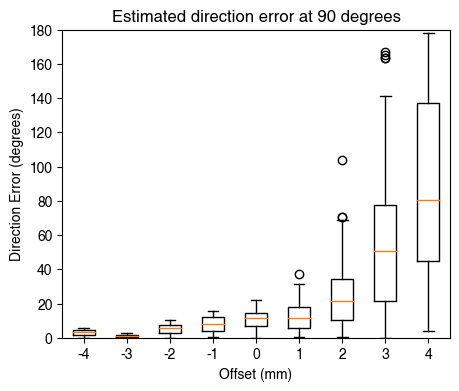

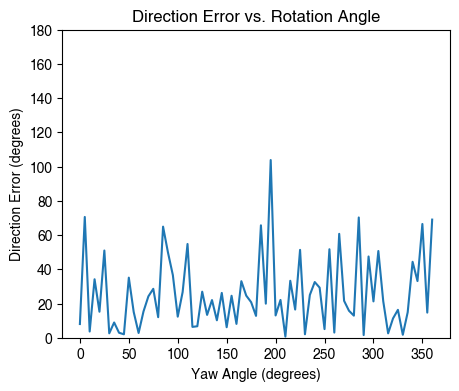

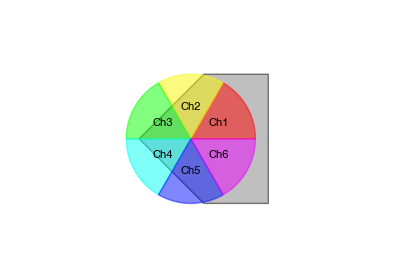

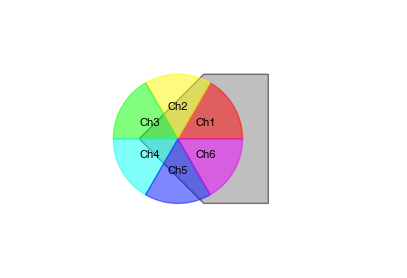

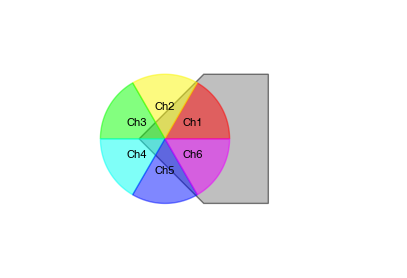

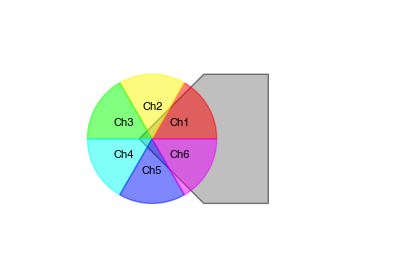

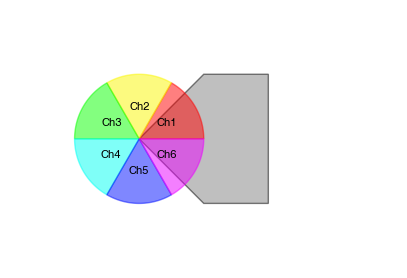

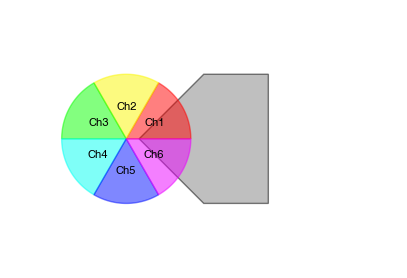

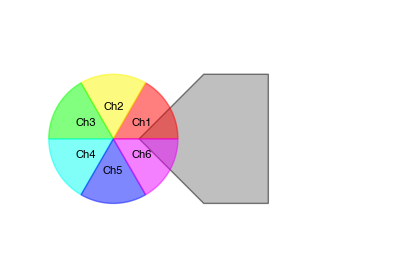

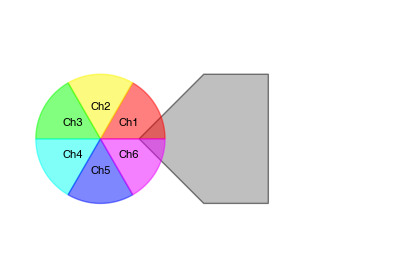

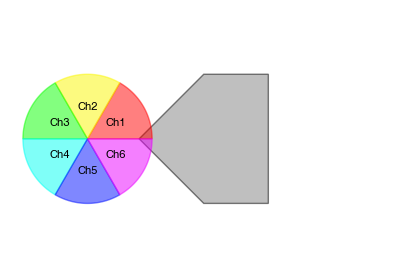

In [97]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
from shapely.geometry.polygon import orient
from shapely.affinity import rotate

class PolygonObject:
    def __init__(self, shape, width, height, position=(0, 0), concave_angle=180):
        self.shape = shape
        self.width = width
        self.height = height
        self.position = position
        self.concave_angle = concave_angle
        self.polygon = self.create_polygon()

    def create_polygon(self):
        x, y = self.position
        if self.shape == "Rectangle":
            coords = [(x, y), (x + self.width, y), (x + self.width, y + self.height), (x, y + self.height)]
        elif self.shape == "Circle":
            coords = [(x + self.width/2 * np.cos(t), y + self.width/2 * np.sin(t)) for t in np.linspace(0, 2*np.pi, 100)]
        elif self.shape == "Ellipse":
            coords = [(x + self.width/2 * np.cos(t), y + self.height/2 * np.sin(t)) for t in np.linspace(0, 2*np.pi, 100)]
        elif self.shape == "Concave":
            coords = [(x, y), (x + self.width, y), (x + self.width, y + self.height), (x, y + self.height)]
            concave_point = ((x + self.height / 2 / np.tan(np.radians(self.concave_angle / 2))), (y + self.height / 2 ))
            # if self.concave_angle != 180:
            coords.insert(4, concave_point)
        else:
            raise ValueError("Unsupported shape")

        return Polygon(coords)
    
    def draw(self, ax):
        x, y = self.polygon.exterior.xy
        ax.fill(x, y, alpha=0.5, fc='gray', ec='black', label='Polygon')

class SuctionCup:
    def __init__(self, num_chambers, radius = 5, center=[0, 0], rotation_angle=0):
        self.num_chambers = num_chambers
        self.radius = radius  # in mm
        self.center = center
        self.rotation_angle = rotation_angle
        # self.chambers_draw = self.create_chambers()
        self.chambers = self.create_chambers()
        # self.subtract_bars()

    def create_chambers(self):
        angles = np.linspace(0, 2 * np.pi, self.num_chambers + 1)
        chambers = []
        for i in range(self.num_chambers):
            theta = np.linspace(angles[i], angles[i + 1], 100)
            x = np.append([self.center[0]], self.center[0] + np.cos(theta) * self.radius)
            y = np.append([self.center[1]], self.center[1] + np.sin(theta) * self.radius)
            chamber_points = list(zip(x, y))
            chamber_polygon = Polygon(chamber_points)
            chamber_polygon = orient(chamber_polygon, sign=1.0)
            chamber_polygon = rotate(chamber_polygon, self.rotation_angle, origin=self.center)
            chambers.append(chamber_polygon)
        return chambers

    def create_bars(self):
        bars = []
        bar_thickness = 0.8  # Adjust thickness as needed
        angle_increment = 360 / self.num_chambers

        for i in range(self.num_chambers):
            angle = i * angle_increment
            bar = Polygon([(-bar_thickness / 2, -self.radius), (bar_thickness / 2, -self.radius), 
                           (bar_thickness / 2, self.radius), (-bar_thickness / 2, self.radius)])
            bar = rotate(bar, angle, origin=(0, 0))
            bars.append(bar)

        return bars

    def subtract_bars(self):
        bars = self.create_bars()
        for bar in bars:
            self.chambers = [chamber.difference(bar) for chamber in self.chambers]
            
    def draw(self, ax):
        colors = plt.cm.get_cmap('hsv', self.num_chambers+1)
        for i, chamber in enumerate(self.chambers):
            x, y = chamber.exterior.xy
            ax.fill(x, y, color=colors(i), alpha=0.5, label=f'Chamber {i + 1}')
            ax.text((x[0] + x[50]) / 2, (y[0] + y[50]) / 2, f'Ch{i + 1}', ha='center', va='center', fontsize=8, color='black')

def calculate_covered_area(polygon, chambers):
    covered_areas = [polygon.intersection(chamber).area for chamber in chambers]
    return covered_areas

def calculate_vacuum_pressures(covered_areas, suctioncup):
    a = 4.007e4
    b = 0.6895
    total_area = np.pi * (suctioncup.radius ** 2) * 1e-6  # Convert to m^2
    total_chamber_area = total_area / suctioncup.num_chambers
    
    r_total = np.sum(covered_areas) * 1e-6 / total_area  # Convert covered areas to m^2
    covered_areas = np.array(covered_areas) * 1e-6  # Ensure it's a NumPy array and convert to m^2
    r_chamber = covered_areas / total_chamber_area
    
    alpha = 0.5 * (r_chamber - r_total)
    P_m = a * total_area + 2 * b
    P_avg = 10 ** (a * np.sum(covered_areas) + b)
    
    vacuum_pressures = [10 ** (alpha_i * P_m) * P_avg ** (1 - alpha_i) for alpha_i in alpha]
    
    # return vacuum_pressures
    # Add noise
    noise = np.random.normal(0, 6, len(vacuum_pressures))
    vacuum_pressures_with_noise = vacuum_pressures + noise
    
    return vacuum_pressures_with_noise

def calculate_unit_vectors(num_chambers, rotation_angle):
    return [np.array([np.cos(2 * np.pi / (num_chambers * 2) + 2 * np.pi * i / num_chambers + np.radians(rotation_angle)),
                      np.sin(2 * np.pi / (num_chambers * 2) + 2 * np.pi * i / num_chambers + np.radians(rotation_angle))])
            for i in range(num_chambers)]

def calculate_direction_vector(unit_vectors, vacuum_pressures):
    direction_vector = np.sum([vp * uv for vp, uv in zip(vacuum_pressures, unit_vectors)], axis=0)
    return direction_vector / np.linalg.norm(direction_vector)

def calculate_direction_errors(direction_vector, target_vector):
    # Calculate the dot product
    dot_product = np.dot(direction_vector, target_vector)
    # Calculate the angle in radians between two vectors
    angle = np.arccos(dot_product)
    # Convert the angle to degrees
    angle = np.degrees(angle)
    return angle

def direction_error_analysis_for_offsets(polygon_obj, suction_cup, offsets, step=5):
    errors_by_offset = []
    angles = np.arange(0, 360+1, step)
    xx, yy = polygon_obj.polygon.exterior.coords.xy
    for offset in offsets:
        suction_cup.center = [xx[4] + offset, yy[4]]
        errors = []
        for angle in angles:
            suction_cup.rotation_angle = angle
            suction_cup.chambers = suction_cup.create_chambers()
            covered_areas = calculate_covered_area(polygon_obj.polygon, suction_cup.chambers)
            vacuum_pressures = calculate_vacuum_pressures(covered_areas, suction_cup)
            unit_vectors = calculate_unit_vectors(suction_cup.num_chambers, suction_cup.rotation_angle)
            direction_vector = calculate_direction_vector(unit_vectors, vacuum_pressures)
            target_vector = np.array([1, 0])  # Unit vector toward positive x direction
            direction_error = calculate_direction_errors(direction_vector, target_vector)
            errors.append(direction_error)
        errors_by_offset.append(errors)
    return angles, errors_by_offset

def plot_direction_error(angles, errors, save_path="direction_error.svg"):
    plt.figure(figsize=(10, 6))
    # plt.plot(angles, errors, marker='o')
    plt.plot(angles, errors)
    plt.ylim(0, 45)
    plt.title('Direction Error vs. Rotation Angle')
    plt.xlabel('Rotation Angle (degrees)')
    plt.ylabel('Direction Error (degrees)')
    # plt.grid(True)
    plt.savefig(save_path, format='svg')
    plt.show()
    
# Plot suction cup and polygon object at certain angle and offset
# input: polygon_obj, suction_cup, angle, offset
def plot_suction_cup_at_angle_and_offset(polygon_obj, suction_cup, angle, offset):
    plt.rcParams['font.family'] = 'Helvetica'
    fig, ax = plt.subplots(figsize=(5, 4))
    polygon_obj.draw(ax)
    suction_cup.rotation_angle = angle
    suction_cup.center[0] += -offset  # Update the center coordinates
    suction_cup.chambers = suction_cup.create_chambers()
    suction_cup.draw(ax)
    ax.set_aspect('equal')
    # limit = max(polygon_obj.width, polygon_obj.height, suction_cup.radius) * 1.5
    # ax.set_xlim(-limit, limit)
    # ax.set_ylim(-limit, limit)
    ax.set_xlim(-15, 15)
    ax.set_ylim(-5, 15)
    ax.axis('off')
    # ax.text(0, offset, f"({0}, {offset})", ha='center', va='center', fontsize=8, color='black')
    # ax.axhline(0, color='black', lw=0.5)  # Add horizontal axis line
    # ax.axvline(0, color='black', lw=0.5)  # Add vertical axis line
    plt.show()
    
    
def plot_direction_error_at_offset(angles, errors, offset, save_path="direction_error.svg"):
    idx = offset + 4
    errors = errors[idx]
    plt.rcParams['font.family'] = 'Helvetica'
    plt.figure(figsize=(5, 4))
    # plt.plot(angles, errors, marker='o')
    plt.plot(angles, errors)
    plt.ylim(0, 180)
    plt.title('Direction Error vs. Rotation Angle')
    plt.xlabel('Yaw Angle (degrees)')
    plt.ylabel('Direction Error (degrees)')
    # plt.grid(True)
    # plt.savefig(save_path, format='svg')
    plt.show()
    
def plot_box_plot(offsets, errors_by_offset, concave_angle):
    # Set the font
    plt.rcParams['font.family'] = 'Helvetica'
    plt.figure(figsize=(5, 4))
    plt.boxplot(errors_by_offset, labels=[offset for offset in offsets])
    plt.xlabel('Offset (mm)')
    plt.ylabel('Direction Error (degrees)')
    plt.title('Estimated direction error at ' + str(concave_angle) + ' degrees')
    plt.grid(False)
    plt.ylim(0, 180)
    plt.show()

if __name__ == "__main__":
    width = 5
    height = 10
    concave_angle = 90
    # polygon_obj = PolygonObject("Rectangle", 10, 10, (0, 0), 180)
    polygon_obj = PolygonObject("Concave", width, height, (0, 0), 360 - concave_angle)
    xx, yy = polygon_obj.polygon.exterior.coords.xy # get the x and y coordinates of the polygon
    suction_cup = SuctionCup(4, 5, [xx[4], yy[4]], 0)
    offsets = np.arange(-4, 5, 1)  # Generate offsets from -4 to 4 by 1
    angles, errors_by_offset = direction_error_analysis_for_offsets(polygon_obj, suction_cup, -offsets, step=5)

    # Plot box plot
    plot_box_plot(offsets, errors_by_offset, concave_angle)
    
    # To do proper visualization, we can plot the suction cup at a certain angle and offset    
    offset = 2
    plot_direction_error_at_offset(angles, errors_by_offset, offset = offset)
    for offset in offsets:
        suction_cup_plot = SuctionCup(6, 5, [xx[4], yy[4]], 0)
        plot_suction_cup_at_angle_and_offset(polygon_obj, suction_cup_plot, angle=0, offset= offset)


## Haptic search algorithm basic

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import time
from shapely.geometry import Polygon
from shapely.geometry.polygon import orient
from shapely.affinity import rotate
from matplotlib.animation import FuncAnimation

class PolygonObject:
    def __init__(self, shape, width, height, position=(0, 0), concave_angle=180):
        self.shape = shape
        self.width = width
        self.height = height
        self.position = position
        self.concave_angle = concave_angle
        self.polygon = self.create_polygon()

    def create_polygon(self):
        x, y = self.position
        if self.shape == "Rectangle":
            coords = [(x, y), (x + self.width, y), (x + self.width, y + self.height), (x, y + self.height)]
        elif self.shape == "Circle":
            coords = [(x + self.width/2 * np.cos(t), y + self.width/2 * np.sin(t)) for t in np.linspace(0, 2*np.pi, 100)]
        elif self.shape == "Ellipse":
            coords = [(x + self.width/2 * np.cos(t), y + self.height/2 * np.sin(t)) for t in np.linspace(0, 2*np.pi, 100)]
        elif self.shape == "Concave":
            coords = [(x, y), (x + self.width, y), (x + self.width, y + self.height), (x, y + self.height)]
            concave_point = ((x + self.height / 2 / np.tan(np.radians(self.concave_angle / 2))), (y + self.height / 2 ))
            # if self.concave_angle != 180:
            coords.insert(4, concave_point)
        else:
            raise ValueError("Unsupported shape")

        return Polygon(coords)
    
    def draw(self, ax):
        x, y = self.polygon.exterior.xy
        ax.fill(x, y, alpha=0.5, fc='gray', ec='black', label='Polygon')

class SuctionCup:
    def __init__(self, num_chambers, radius = 5, center=[0, 0], rotation_angle=0):
        self.num_chambers = num_chambers
        self.radius = radius  # in mm
        self.suction_cup_area = np.pi * (self.radius ** 2)
        self.center = np.array(center)
        self.rotation_angle = rotation_angle
        self.direction_vector = np.array([0, 0])
        # self.chambers_draw = self.create_chambers()
        self.chambers = self.create_chambers()
        # self.subtract_bars()

    def create_chambers(self):
        angles = np.linspace(0, 2 * np.pi, self.num_chambers + 1)
        chambers = []
        for i in range(self.num_chambers):
            theta = np.linspace(angles[i], angles[i + 1], 1000)
            x = np.append([self.center[0]], self.center[0] + np.cos(theta) * self.radius)
            y = np.append([self.center[1]], self.center[1] + np.sin(theta) * self.radius)
            chamber_points = list(zip(x, y))
            chamber_polygon = Polygon(chamber_points)
            chamber_polygon = orient(chamber_polygon, sign=1.0)
            chamber_polygon = rotate(chamber_polygon, self.rotation_angle, origin=self.center)
            chambers.append(chamber_polygon)
        return chambers

    def create_bars(self):
        bars = []
        bar_thickness = 0.8  # Adjust thickness as needed
        angle_increment = 360 / self.num_chambers

        for i in range(self.num_chambers):
            angle = i * angle_increment
            bar = Polygon([(-bar_thickness / 2, -self.radius), (bar_thickness / 2, -self.radius), 
                           (bar_thickness / 2, self.radius), (-bar_thickness / 2, self.radius)])
            bar = rotate(bar, angle, origin=(0, 0))
            bars.append(bar)

        return bars

    def subtract_bars(self):
        bars = self.create_bars()
        for bar in bars:
            self.chambers = [chamber.difference(bar) for chamber in self.chambers]
            
    def draw(self, ax):
        colors = plt.cm.get_cmap('hsv', self.num_chambers+1)
        for i, chamber in enumerate(self.chambers):
            x, y = chamber.exterior.xy
            ax.fill(x, y, color=colors(i), alpha=0.5, label=f'Chamber {i + 1}')
            ax.text((x[0] + x[50]) / 2, (y[0] + y[50]) / 2, f'Ch{i + 1}', ha='center', va='center', fontsize=8, color='black')

def calculate_covered_area(polygon, chambers):
    covered_areas = [polygon.intersection(chamber).area for chamber in chambers]
    return covered_areas

def calculate_vacuum_pressures(covered_areas, suctioncup):
    a = 4.007e4
    b = 0.6895
    total_area = suctioncup.suction_cup_area * 1e-6  # Convert to m^2
    total_chamber_area = total_area / suctioncup.num_chambers
    
    r_total = np.sum(covered_areas) * 1e-6 / total_area  # Convert covered areas to m^2
    covered_areas = np.array(covered_areas) * 1e-6  # Ensure it's a NumPy array and convert to m^2
    r_chamber = covered_areas / total_chamber_area
    
    alpha = 0.5 * (r_chamber - r_total)
    P_m = a * total_area + 2 * b
    P_avg = 10 ** (a * np.sum(covered_areas) + b)
    
    vacuum_pressures = [10 ** (alpha_i * P_m) * P_avg ** (1 - alpha_i) for alpha_i in alpha]
    
    # return vacuum_pressures
    # Add noise
    noise = np.random.normal(0, 6, len(vacuum_pressures))
    vacuum_pressures_with_noise = vacuum_pressures + noise
    
    return vacuum_pressures_with_noise

def calculate_unit_vectors(num_chambers, rotation_angle):
    return [np.array([np.cos(2 * np.pi / (num_chambers * 2) + 2 * np.pi * i / num_chambers + np.radians(rotation_angle)),
                      np.sin(2 * np.pi / (num_chambers * 2) + 2 * np.pi * i / num_chambers + np.radians(rotation_angle))])
            for i in range(num_chambers)]

def calculate_direction_vector(unit_vectors, vacuum_pressures):
    direction_vector = np.sum([vp * uv for vp, uv in zip(vacuum_pressures, unit_vectors)], axis=0)
    return direction_vector / np.linalg.norm(direction_vector)

def calculate_direction_errors(direction_vector, target_vector):
    # Calculate the dot product
    dot_product = np.dot(direction_vector, target_vector)
    # Calculate the angle in radians between two vectors
    angle = np.arccos(dot_product)
    # Convert the angle to degrees
    angle = np.degrees(angle)
    return angle

def direction_error_analysis_for_offsets(polygon_obj, suction_cup, offsets, step=5):
    errors_by_offset = []
    angles = np.arange(0, 360+1, step)
    xx, yy = polygon_obj.polygon.exterior.coords.xy
    for offset in offsets:
        suction_cup.center = [xx[4] + offset, yy[4]]
        errors = []
        for angle in angles:
            suction_cup.rotation_angle = angle
            suction_cup.chambers = suction_cup.create_chambers()
            covered_areas = calculate_covered_area(polygon_obj.polygon, suction_cup.chambers)
            vacuum_pressures = calculate_vacuum_pressures(covered_areas, suction_cup)
            unit_vectors = calculate_unit_vectors(suction_cup.num_chambers, suction_cup.rotation_angle)
            direction_vector = calculate_direction_vector(unit_vectors, vacuum_pressures)
            target_vector = np.array([1, 0])  # Unit vector toward positive x direction
            direction_error = calculate_direction_errors(direction_vector, target_vector)
            errors.append(direction_error)
        errors_by_offset.append(errors)
    return angles, errors_by_offset

def unit_direction_vector(polygon_obj, suction_cup):
    covered_areas = calculate_covered_area(polygon_obj.polygon, suction_cup.chambers)
    vacuum_pressures = calculate_vacuum_pressures(covered_areas, suction_cup)
    unit_vectors = calculate_unit_vectors(suction_cup.num_chambers, suction_cup.rotation_angle)
    return calculate_direction_vector(unit_vectors, vacuum_pressures)

# def check_suction(polygon_obj, suction_cup):
#     covered_areas = calculate_covered_area(polygon_obj.polygon, suction_cup.chambers)
#     return True if np.sum(covered_areas) == suction_cup.suction_cup_area else False

def check_suction(polygon_obj, suction_cup):
    total_covered_area = sum([polygon_obj.polygon.intersection(chamber).area for chamber in suction_cup.chambers])
    tolerance = 1e-4  # Define a tolerance value for floating-point comparison
    return abs(total_covered_area - suction_cup.suction_cup_area) < tolerance

def plot_direction_error(angles, errors, save_path="direction_error.svg"):
    plt.figure(figsize=(10, 6))
    # plt.plot(angles, errors, marker='o')
    plt.plot(angles, errors)
    plt.ylim(0, 45)
    plt.title('Direction Error vs. Rotation Angle')
    plt.xlabel('Rotation Angle (degrees)')
    plt.ylabel('Direction Error (degrees)')
    # plt.grid(True)
    plt.savefig(save_path, format='svg')
    plt.show()
    
# Plot suction cup and polygon object at certain angle and offset
# input: polygon_obj, suction_cup, angle, offset
def plot_suction_cup_at_angle_and_offset(polygon_obj, suction_cup, angle, offset):
    plt.rcParams['font.family'] = 'Helvetica'
    fig, ax = plt.subplots(figsize=(5, 4))
    polygon_obj.draw(ax)
    suction_cup.rotation_angle = angle
    suction_cup.center[0] += -offset  # Update the center coordinates
    suction_cup.chambers = suction_cup.create_chambers()
    suction_cup.draw(ax)
    ax.set_aspect('equal')
    # limit = max(polygon_obj.width, polygon_obj.height, suction_cup.radius) * 1.5
    # ax.set_xlim(-limit, limit)
    # ax.set_ylim(-limit, limit)
    ax.set_xlim(-15, 15)
    ax.set_ylim(-5, 15)
    ax.axis('off')
    # ax.text(0, offset, f"({0}, {offset})", ha='center', va='center', fontsize=8, color='black')
    # ax.axhline(0, color='black', lw=0.5)  # Add horizontal axis line
    # ax.axvline(0, color='black', lw=0.5)  # Add vertical axis line
    plt.show()
    
def plot_polygon_and_suction_cup(polygon_obj, suction_cup):
    fig, ax = plt.subplots(figsize=(5, 4))
    polygon_obj.draw(ax)
    suction_cup.draw(ax)
    ax.set_aspect('equal')
    # ax.set_xlim(-15, 15)
    # ax.set_ylim(-5, 15)
    ax.axis('off')
    plt.show()
    
    
def plot_direction_error_at_offset(angles, errors, offset, save_path="direction_error.svg"):
    idx = offset + 4
    errors = errors[idx]
    plt.rcParams['font.family'] = 'Helvetica'
    plt.figure(figsize=(5, 4))
    # plt.plot(angles, errors, marker='o')
    plt.plot(angles, errors)
    plt.ylim(0, 180)
    plt.title('Direction Error vs. Rotation Angle')
    plt.xlabel('Yaw Angle (degrees)')
    plt.ylabel('Direction Error (degrees)')
    # plt.grid(True)
    # plt.savefig(save_path, format='svg')
    plt.show()
    
def plot_box_plot(offsets, errors_by_offset, concave_angle):
    # Set the font
    plt.rcParams['font.family'] = 'Helvetica'
    plt.figure(figsize=(5, 4))
    plt.boxplot(errors_by_offset, labels=[offset for offset in offsets])
    plt.xlabel('Offset (mm)')
    plt.ylabel('Direction Error (degrees)')
    plt.title('Estimated direction error at ' + str(concave_angle) + ' degrees')
    plt.grid(False)
    plt.ylim(0, 180)
    plt.show()
    
def animate_suction_cup(polygon_obj, suction_cup, haptic_path, step_size=1):
    plot_polygon_and_suction_cup(polygon_obj, suction_cup)
    while not check_suction(polygon_obj, suction_cup):
        suction_cup.direction_vector = unit_direction_vector(polygon_obj, suction_cup)
        suction_cup.center = suction_cup.center + step_size * suction_cup.direction_vector
        suction_cup.chambers = suction_cup.create_chambers()
        haptic_path = np.vstack((haptic_path, suction_cup.center))
        plot_polygon_and_suction_cup(polygon_obj, suction_cup)
        plt.cla()

if __name__ == "__main__":
    
    # Define the polygon object
    width = 10
    height = 15
    concave_angle = 90
    polygon_obj = PolygonObject("Concave", width, height, (0, 0), 360 - concave_angle)
    xx, yy = polygon_obj.polygon.exterior.coords.xy # get the x and y coordinates of the polygon
    
    # Define the suction cup
    num_chambers = 4
    suction_cup_radius = 5
    initial_yaw_angle = 0
    suction_cup_center = [xx[4], yy[4]]
    suction_cup = SuctionCup(num_chambers, suction_cup_radius, suction_cup_center, initial_yaw_angle)
    
    # Define haptic search parameters and data matrix
    step_size = 1  # in mm
    haptic_path = suction_cup.center
    
    # Animate the suction cup movement
    fig = plt.figure()
    ani = FuncAnimation(fig, animate_suction_cup, fargs=(polygon_obj, suction_cup, haptic_path, step_size), interval=1000, repeat=False)
    
    # # 0. plot initial position of the suction cup
    # plot_polygon_and_suction_cup(polygon_obj, suction_cup)
    
    # while not check_suction(polygon_obj, suction_cup):
    
    #     # 1. calulate the direction vector
    #     suction_cup.direction_vector = unit_direction_vector(polygon_obj, suction_cup)
        
    #     # 2. move the suction cup to a new position and save to the hatic path
    #     suction_cup.center = suction_cup.center + step_size * suction_cup.direction_vector
    #     suction_cup.chambers = suction_cup.create_chambers()
    #     haptic_path = np.vstack((haptic_path, suction_cup.center))
        
    #     # 3. plot the new position of the suction cup
    #     plot_polygon_and_suction_cup(polygon_obj, suction_cup)

    #     # Add delay for visualization
    #     time.sleep(1)
        
    #     # 4. clear the plot for the animation
    #     plt.cla()
    
    
    
    


<Figure size 640x480 with 0 Axes>

## Haptic search algorithm

In [20]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
from shapely.geometry.polygon import orient
from shapely.affinity import rotate
from matplotlib.animation import FuncAnimation

# Use %matplotlib notebook for interactive plotting
%matplotlib notebook

class PolygonObject:
    def __init__(self, shape, width, height, position=(0, 0), concave_angle=180):
        self.shape = shape
        self.width = width
        self.height = height
        self.position = position
        self.concave_angle = concave_angle
        self.polygon = self.create_polygon()

    def create_polygon(self):
        x, y = self.position
        if self.shape == "Rectangle":
            coords = [(x, y), (x + self.width, y), (x + self.width, y + self.height), (x, y + self.height)]
        elif self.shape == "Circle":
            coords = [(x + self.width / 2 * np.cos(t), y + self.width / 2 * np.sin(t)) for t in np.linspace(0, 2 * np.pi, 100)]
        elif self.shape == "Ellipse":
            coords = [(x + self.width / 2 * np.cos(t), y + self.height / 2 * np.sin(t)) for t in np.linspace(0, 2 * np.pi, 100)]
        elif self.shape == "Concave":
            coords = [(x, y), (x + self.width, y), (x + self.width, y + self.height), (x, y + self.height)]
            concave_point = ((x + self.height / 2 / np.tan(np.radians(self.concave_angle / 2))), (y + self.height / 2))
            if self.concave_angle != 180:
                coords.insert(4, concave_point)
        else:
            raise ValueError("Unsupported shape")

        return Polygon(coords)
    
    def draw(self, ax):
        x, y = self.polygon.exterior.xy
        self.polygon_patch = ax.fill(x, y, alpha=0.5, fc='gray', ec='black', label='Polygon')[0]

class SuctionCup:
    def __init__(self, num_chambers, radius=5, center=[0, 0], rotation_angle=0):
        self.num_chambers = num_chambers
        self.radius = radius  # in mm
        self.center = center
        self.rotation_angle = rotation_angle
        self.chambers = self.create_chambers()

    def create_chambers(self):
        angles = np.linspace(0, 2 * np.pi, self.num_chambers + 1)
        chambers = []
        for i in range(self.num_chambers):
            theta = np.linspace(angles[i], angles[i + 1], 100)
            x = np.append([self.center[0]], self.center[0] + np.cos(theta) * self.radius)
            y = np.append([self.center[1]], self.center[1] + np.sin(theta) * self.radius)
            chamber_points = list(zip(x, y))
            chamber_polygon = Polygon(chamber_points)
            chamber_polygon = orient(chamber_polygon, sign=1.0)
            chamber_polygon = rotate(chamber_polygon, self.rotation_angle, origin=self.center)
            chambers.append(chamber_polygon)
        return chambers

    def draw(self, ax):
        self.chamber_patches = []
        colors = plt.cm.get_cmap('hsv', self.num_chambers + 1)
        for i, chamber in enumerate(self.chambers):
            x, y = chamber.exterior.xy
            patch = ax.fill(x, y, color=colors(i), alpha=0.5, label=f'Chamber {i + 1}')[0]
            self.chamber_patches.append(patch)

def animate_suction_cup_movement(polygon_obj, suction_cup, step_size=1, interval=100):
    fig, ax = plt.subplots()
    polygon_obj.draw(ax)
    
    def update(frame):
        suction_cup.center[0] += step_size
        suction_cup.chambers = suction_cup.create_chambers()
        for patch in suction_cup.chamber_patches:
            patch.remove()
        suction_cup.draw(ax)
        ax.set_aspect('equal')
        limit = max(polygon_obj.width, polygon_obj.height, suction_cup.radius) * 1.5
        ax.set_xlim(-limit, limit)
        ax.set_ylim(-limit, limit)
        ax.axhline(0, color='black', lw=0.5)
        ax.axvline(0, color='black', lw=0.5)
    
    ani = FuncAnimation(fig, update, frames=np.arange(0, 100, step_size), interval=interval)
    plt.show()
    return ani  # Keep a reference to the animation object

if __name__ == "__main__":
    width = 10
    height = 10
    concave_angle = 180
    rotation_angle = 0
    polygon_obj = PolygonObject("Concave", width, height, (0, 0), concave_angle)
    suction_cup = SuctionCup(4, 5, [(height / 2 / np.tan(np.radians(concave_angle / 2))), height / 2], rotation_angle)

    print("Suction Cup Center: ", suction_cup.center)
    # Animation for suction cup movement until it fully covers the polygon
    animate_suction_cup_movement(polygon_obj, suction_cup)


Suction Cup Center:  [3.061616997868383e-16, 5.0]


<IPython.core.display.Javascript object>

In [8]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
from shapely.geometry.polygon import orient
from shapely.affinity import rotate
from matplotlib.animation import FuncAnimation

# Use %matplotlib notebook for interactive plotting
%matplotlib notebook

class PolygonObject:
    def __init__(self, shape, width, height, position=(0, 0), concave_angle=180):
        self.shape = shape
        self.width = width
        self.height = height
        self.position = position
        self.concave_angle = concave_angle
        self.polygon = self.create_polygon()

    def create_polygon(self):
        x, y = self.position
        if self.shape == "Rectangle":
            coords = [(x, y), (x + self.width, y), (x + self.width, y + self.height), (x, y + self.height)]
        elif self.shape == "Circle":
            coords = [(x + self.width / 2 * np.cos(t), y + self.width / 2 * np.sin(t)) for t in np.linspace(0, 2 * np.pi, 100)]
        elif self.shape == "Ellipse":
            coords = [(x + self.width / 2 * np.cos(t), y + self.height / 2 * np.sin(t)) for t in np.linspace(0, 2 * np.pi, 100)]
        elif self.shape == "Concave":
            coords = [(x, y), (x + self.width, y), (x + self.width, y + self.height), (x, y + self.height)]
            concave_point = ((x + self.height / 2 / np.tan(np.radians(self.concave_angle / 2))), (y + self.height / 2))
            if self.concave_angle != 180:
                coords.insert(4, concave_point)
        else:
            raise ValueError("Unsupported shape")

        return Polygon(coords)
    
    def draw(self, ax):
        x, y = self.polygon.exterior.xy
        self.polygon_patch = ax.fill(x, y, alpha=0.5, fc='gray', ec='black', label='Polygon')[0]

class SuctionCup:
    def __init__(self, num_chambers, radius=5, center=[0, 0], rotation_angle=0):
        self.num_chambers = num_chambers
        self.radius = radius  # in mm
        self.center = center
        self.rotation_angle = rotation_angle
        self.chambers = self.create_chambers()

    def create_chambers(self):
        angles = np.linspace(0, 2 * np.pi, self.num_chambers + 1)
        chambers = []
        for i in range(self.num_chambers):
            theta = np.linspace(angles[i], angles[i + 1], 100)
            x = np.append([self.center[0]], self.center[0] + np.cos(theta) * self.radius)
            y = np.append([self.center[1]], self.center[1] + np.sin(theta) * self.radius)
            chamber_points = list(zip(x, y))
            chamber_polygon = Polygon(chamber_points)
            chamber_polygon = orient(chamber_polygon, sign=1.0)
            chamber_polygon = rotate(chamber_polygon, self.rotation_angle, origin=self.center)
            chambers.append(chamber_polygon)
        return chambers

    def draw(self, ax):
        self.chamber_patches = []
        colors = plt.cm.get_cmap('hsv', self.num_chambers + 1)
        for i, chamber in enumerate(self.chambers):
            x, y = chamber.exterior.xy
            patch = ax.fill(x, y, color=colors(i), alpha=0.5, label=f'Chamber {i + 1}')[0]
            self.chamber_patches.append(patch)

def animate_suction_cup_movement(polygon_obj, suction_cup, step_size=1, interval=100):
    fig, ax = plt.subplots()
    polygon_obj.draw(ax)
    
    def update(frame):
        suction_cup.center[0] += step_size
        suction_cup.chambers = suction_cup.create_chambers()
        for patch in suction_cup.chamber_patches:
            patch.remove()
        suction_cup.draw(ax)
        ax.set_aspect('equal')
        limit = max(polygon_obj.width, polygon_obj.height, suction_cup.radius) * 1.5
        ax.set_xlim(-limit, limit)
        ax.set_ylim(-limit, limit)
        ax.axhline(0, color='black', lw=0.5)
        ax.axvline(0, color='black', lw=0.5)
    
    ani = FuncAnimation(fig, update, frames=np.arange(0, 100, step_size), interval=interval)
    plt.show()
    return ani  # Keep a reference to the animation object

if __name__ == "__main__":
    width = 10
    height = 10
    concave_angle = 180
    rotation_angle = 0
    polygon_obj = PolygonObject("Concave", width, height, (0, 0), concave_angle)
    suction_cup = SuctionCup(4, 5, [(height / 2 / np.tan(np.radians(concave_angle / 2))), height / 2], rotation_angle)

    print("Suction Cup Center: ", suction_cup.center)
    # Animation for suction cup movement until it fully covers the polygon
    animate_suction_cup_movement(polygon_obj, suction_cup)


Suction Cup Center:  [3.061616997868383e-16, 5.0]


<IPython.core.display.Javascript object>